In [ ]:
import csv 
import json 
import requests
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib 
import seaborn as sns

In [38]:
#Durchsuchung von Subreddits. Es wird das "Data"-object betrachtet
def GetSubmissions (subreddit, queries, size, date_from, date_to, sort_type):
    url = f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit}&q={'+'.join(queries)}&size={size}&after={date_from}&before={date_to}&sort_type={sort_type}" 
    while True:
        try:
            response = requests.get(url)
            response.raise_for_status()
            data_subm = response.json()["data"]
            print(url)
            print("Status Code: 200 -> funktioniert")
            return data_subm
        except requests.exceptions.HTTPError as errh: 
            print("HTTP Error:", errh)
            print("Versuche erneut in 5 Sekunden...")
            time.sleep(5)
            continue
        except requests.exceptions.Timeout as errt: 
            print("Timeout Error:", errt)
            print("Versuche erneut in 5 Sekunden...")
            time.sleep(5)
            continue
        except requests.exceptions.RequestException as err:
            print("Error:", err)
            break

In [39]:
#Durchsuchung von Subreddits. Es wird das "Data"-object betrachtet. Von "List" zu "CSV"

def GetComments(subreddit, queries, size, date_from, date_to, sort_type):
    url = f"https://api.pushshift.io/reddit/search/comment/?subreddit={subreddit}&q={'+'.join(queries)}&size={size}&after={date_from}&before={date_to}&sort_type={sort_type}"
    
    while True:
        try:
            response = requests.get(url)
            response.raise_for_status()
            data_com = response.json()["data"]
            print("Status code: 200 -> funktioniert")
            print(url)
            return data_com
        except requests.exceptions.HTTPError as errh:
            print("HTTP Error:", errh)
            print("Retrying in 5 seconds...")
            time.sleep(5)
            continue
        except requests.exceptions.Timeout as errt:
            print("Timeout Error:", errt)
            print("Retrying in 5 seconds...")
            time.sleep(5)
            continue
        except requests.exceptions.RequestException as err:
            print("Error:", err)
            break


In [40]:
#Umwandlung der json response zu einer csv 

def data_to_csv(filename, data, data_needed):
    with open(filename, mode="w", newline="") as file:
        writer=csv.writer(file)
        writer.writerow(data_needed)
        for submission in data:
                writer.writerow(submission[theme] for theme in data_needed)

In [41]:
#Um das Limit von 1000 Subreddits/Comments zu überschreiten, werden mehrere Queries verwendent und die csv nacheinander erweitert.
#Es wird zudem ein Data Frame erstellt, welcher ausgibt, wieviele Subreddits/Comments mit den jeweiligen Queries gefunden wurden. 
#Es wird mit timestamps gesucht. Es wird ab der Erstellung des Subreddits 'uberdrivers'gesucht. 

def CombineAllTheData(subreddit, queries, subr_or_com):
    
    combined_subr = []
    combined_coms = []
    found_coms = pd.DataFrame(columns=["Searched for", "found comments"]) 
    found_subr = pd.DataFrame(columns=["Searched for", "found subreddits"])
    
    if subr_or_com == 1: 
        print("es werden Subreddits untersucht")
        data_needed = ['title', 'author', 'created_utc', 'num_comments', 'score', 'permalink', "created_utc","url"]
        for keywords in queries:
            temp_data = GetSubmissions(subreddit, keywords, 1000, 1383642474, 1683104943, "score")
            combined_subr = combined_subr + temp_data
            
            new_row = pd.DataFrame({"Searched for": [keywords], "found subreddits": [len(temp_data)]})
            found_subr = pd.concat([found_subr, new_row], ignore_index=True)
        
        
        #combined_subr["Date"]=pd.to_datetime(combined_subr["created_utc"])
        data_to_csv("subreddits.csv", combined_subr, data_needed)
        print(found_subr)
        
    if subr_or_com == 0:
        print("es werden comments untersucht") 
        data_needed = ["body", "subreddit", "score", "author", "created_utc", "link_id"]
        for keywords in queries:
            temp_data = GetComments(subreddit, keywords, 1000, 1383642474, 1683104943, "score")
            combined_coms = combined_coms + temp_data
            
            new_row = pd.DataFrame({"Searched for": [keywords], "found comments": [len(temp_data)]})
            found_coms = pd.concat([found_coms, new_row], ignore_index=True)
            #print(len(combined_coms))
        
        #combined_coms["Date"]=pd.to_datetime(combined_coms["created_utc"])
        data_to_csv("comments.csv", combined_coms, data_needed)
        print(found_coms)
        
      
    return (found_coms, found_subr)

In [42]:
#AUSFÜHRUNG

Queries = [["algorithm", "intransparent"], 
           ["algorithm", "unfair"], 
           ["unfair", "intransparent"], 
           ["unfair", "treatment"], 
           ["poor","matching"], 
           ["arbitrary", "decisions"], 
           ["low","pay"], 
           ["high","fees"], 
           ["long", "wait", "times"], 
           ["poor", "communication"], 
           ["lack", "of", "transparency"], 
           ["lack", "of", "information"], 
           ["information", "overload"], 
           ["too", "much", "information"]]

for i in range(0, 2):
    if i == 0:
        Map_Comments, Platzhalter = CombineAllTheData("uberdrivers", Queries, i)
    
    if i == 1:
        Platzhalter, Map_Subreddits = CombineAllTheData("uberdrivers", Queries, i)
    print("")

es werden comments untersucht
Status code: 200 -> funktioniert
https://api.pushshift.io/reddit/search/comment/?subreddit=uberdrivers&q=algorithm+intransparent&size=1000&after=1383642474&before=1683104943&sort_type=score
Status code: 200 -> funktioniert
https://api.pushshift.io/reddit/search/comment/?subreddit=uberdrivers&q=algorithm+unfair&size=1000&after=1383642474&before=1683104943&sort_type=score
Status code: 200 -> funktioniert
https://api.pushshift.io/reddit/search/comment/?subreddit=uberdrivers&q=unfair+intransparent&size=1000&after=1383642474&before=1683104943&sort_type=score
Status code: 200 -> funktioniert
https://api.pushshift.io/reddit/search/comment/?subreddit=uberdrivers&q=unfair+treatment&size=1000&after=1383642474&before=1683104943&sort_type=score
Status code: 200 -> funktioniert
https://api.pushshift.io/reddit/search/comment/?subreddit=uberdrivers&q=poor+matching&size=1000&after=1383642474&before=1683104943&sort_type=score
Status code: 200 -> funktioniert
https://api.pu

In [43]:
'''DATENEXPLORATION FÜR COMMENTS 
    - Anzahl comments
    - Anzahl Kommentare eines Autors 
    - Anzahl verschiedene Autoren 
    - Zeitpunkt erster und letzter Comment --> Zeitraum 
    '''

def Exploration_Comments():
    data = pd.read_csv("comments.csv")
    data.sort_values(by=["score"], inplace=True, ascending=False)
    data["Date"]=pd.to_datetime(data["created_utc"], unit="s") 
    
    data.to_csv("comments_sorted_by_Score.csv")
    
    num_of_comments = len(data)
    print("Es wurden " + str(num_of_comments) + " Comments gefunden")
    
    freq_authors = data.groupby('author').size().reset_index(name='number of comments')
    freq_authors.sort_values(by="number of comments", inplace=True, ascending=False)
      
    # print(type(freq_authors))
    # print(type(data))
    # print(freq_authors)
    
    num_of_authors = len(freq_authors)
    print("Die Comments wurden von", num_of_authors, "verschiedenen Usern geschrieben")
    
    earliest_com = data["Date"].min()
    latest_com = data["Date"].max()
    print("Der erste Kommentar des Datensatzes wurde", earliest_com, "geschrieben")
    print("Der letzte Kommentar des Datensartes wurde", latest_com, "geschrieben")
    
    matplotlib.style.use("ggplot")
    Map_Comments.plot.bar(x="Searched for", y="found comments")
    
    return num_of_comments, freq_authors 

Es wurden 2373 Comments gefunden
Die Comments wurden von 1439 verschiedenen Usern geschrieben
Der erste Kommentar des Datensatzes wurde 2014-02-05 23:11:42 geschrieben
Der letzte Kommentar des Datensartes wurde 2023-05-01 12:30:15 geschrieben


(2373,
                  author  number of comments
 178            DCHacker                  31
 1091         jaysonm007                  28
 851           [deleted]                  23
 401             Keraiza                  15
 536             Nythain                  14
 ...                 ...                 ...
 546    Ok_Anywhere_1791                   1
 545         OkAerie2360                   1
 543         Ok-Nail6186                   1
 542   Officer_Olive_Oil                   1
 1438             zxcwar                   1
 
 [1439 rows x 2 columns])

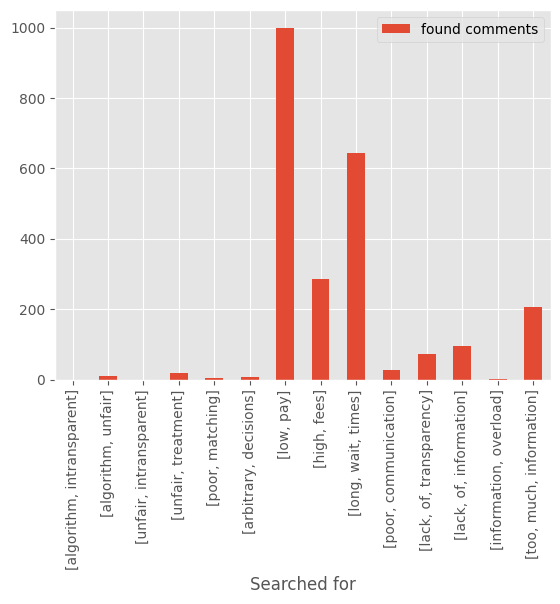

In [44]:
Exploration_Comments()

In [45]:
'''DATENEXPLORATION FÜR SUBREDDITS 
    - Anzahl SUBREDDITS
    - Anzahl Kommentare eines Autors 
    - Anzahl verschiedene Autoren 
    - Zeitpunkt erster und letzter Subreddit --> Zeitraum 
    '''

def Exploration_Subreddits():
    data = pd.read_csv("subreddits.csv")
    data.sort_values(by=["score"], inplace=True, ascending=False)
    data["Date"]=pd.to_datetime(data["created_utc"], unit="s") 
    
    data.to_csv("subreddits_sorted_by_Score.csv")
    
    num_of_subreddits = len(data)
    print("Es wurden " + str(num_of_subreddits) + " subreddits gefunden")
    
    freq_authors = data.groupby('author').size().reset_index(name='number of subreddits')
    freq_authors.sort_values(by="number of subreddits", inplace=True, ascending=False)
      
    # print(type(freq_authors))
    # print(type(data))
    # print(freq_authors)
    
    num_of_authors = len(freq_authors)
    print("Die Subreddits wurden von", num_of_authors, "verschiedenen Usern geschrieben")
    
    earliest_subr = data["Date"].min()
    latest_subr = data["Date"].max()
    print("Das erste Subreddit des Datensatzes wurde", earliest_subr, "geschrieben")
    print("Das letzte Subreddit des Datensartes wurde", latest_subr, "geschrieben")
    
    matplotlib.style.use("ggplot")
    Map_Subreddits.plot.bar(x="Searched for", y="found subreddits")
    
    return num_of_subreddits, freq_authors 

Es wurden 687 subreddits gefunden
Die Subreddits wurden von 572 verschiedenen Usern geschrieben
Das erste Subreddit des Datensatzes wurde 2014-03-29 23:55:37 geschrieben
Das letzte Subreddit des Datensartes wurde 2023-05-01 14:53:18 geschrieben


(687,
                    author  number of subreddits
 328             [deleted]                    23
 12   Accomplished-Sky8281                     7
 17             Alarm_Only                     6
 319               XJadynX                     4
 300            TurkeyJoke                     4
 ..                    ...                   ...
 199   No_Requirement_1453                     1
 198         NickCharlesYT                     1
 197          NickBosaDPOY                     1
 196        NewportShortie                     1
 571            yung40oz84                     1
 
 [572 rows x 2 columns])

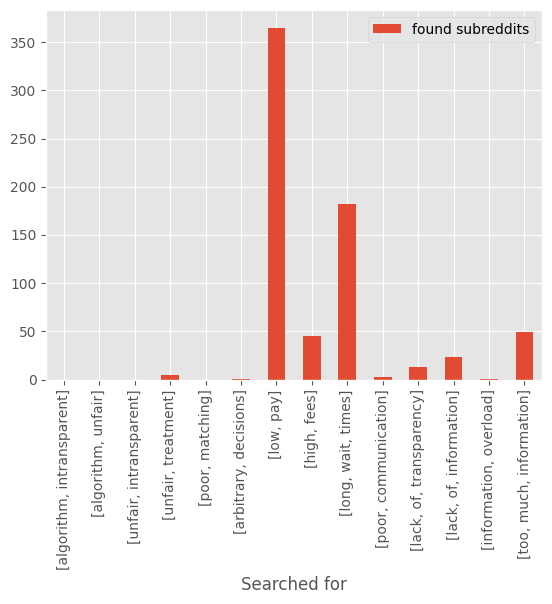

In [46]:
Exploration_Subreddits()